# **Bank Customer Exit Predictor (CI PP-5)** 

# **ML Modeling : Regression**

## Objectives

* To fit and evaluate a regression based model and predict when a customer will exit.

## Inputs

* outputs/datasets/collection/BankCustomerData.csv
* Data cleaning and Feature Engineering steps and conclusions based on respective notebooks.

## Outputs

* Train and Test set (Features and Target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline to predict tenure
* Feature Importance Plot

# Change working directory

* Notebooks are being stored in a subfolder, therefore when running the notebook in the editor, we need to change the working directory from its current folder to parent folder

1. We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/BankCustomerExitPredictor/jupyter_notebooks'

2. We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You have set a new current directory")

You have set a new current directory


3. Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/BankCustomerExitPredictor'

---

# Load Data

*  Loading dataset from outputs folder, however we are not including variables: CustomerID, Surname and RowNumber as they are just identifiers and dont impact the exit study. Also we are removing non-exited as we are only need to analyse exited cases (exited=1)

* We are removing missing data from ['Age', 'Geography', 'HasCrCard', 'IsActiveMember'] as the missing data level is not significant.

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/BankCustomerData.csv")
      .query("Exited == 1")
      .drop(labels=['CustomerId', 'Surname', 'RowNumber','Exited'], axis=1) 
  )
df.dropna(inplace=True) 
print(df.shape)
df.head(3)

(2037, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71


# ML Pipeline: Regression

### 1. ML Pipeline 

* Basis Data cleaning and Feature Engineering notebooks we prepare pipleline.
* We dont require any data cleaning steps.

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),
        ("log", vt.LogTransformer(variables=['Age']) ),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 2. Custom Class for Hyperparameter Optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Tenure'], axis=1),
    df['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


# Grid Search CV - Sklearn

1. Using Algorithms with standard hyperparameters to identify most suitable algorithm

In [8]:
models_default = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_default = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

2. Hyperparameter optimisation search usin default parameters

In [9]:
best_alg = HyperparameterOptimizationSearch(models=models_default, params=params_default)
best_alg.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is d

3. Checking Score Summary

In [10]:
grid_search_summary, grid_search_pipelines = best_alg.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,-0.025692,-0.002897,0.007471,0.011953
4,AdaBoostRegressor,-0.011774,-0.005138,0.000841,0.005127
2,RandomForestRegressor,-0.166293,-0.066118,-0.011217,0.055059
5,GradientBoostingRegressor,-0.129582,-0.068548,-0.042386,0.031655
3,ExtraTreesRegressor,-0.199101,-0.123657,-0.054385,0.062133
6,XGBRegressor,-0.384375,-0.235532,-0.143937,0.081561
1,DecisionTreeRegressor,-1.206542,-1.045927,-0.838896,0.118488


### Identifying best hyperparameter configuration for top two ML Algorithms

1. Defining top two models and parameters for further analysis

* The classes represent the following ranges: 
{'Tenure': [-inf, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, inf]} 



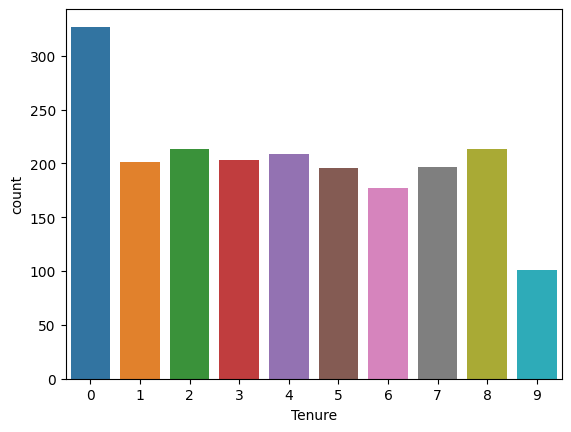

In [11]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
import seaborn as sns
import matplotlib.pyplot as plt
disc = EqualFrequencyDiscretiser(q=10, variables=['Tenure']) 
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='Tenure')
plt.show()

In [12]:
df_clf.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42.0,1,0.00,1,1.0,1.0,101348.88
2,502,France,Female,42.0,7,159660.80,3,1.0,0.0,113931.57
5,645,Spain,Male,44.0,7,113755.78,2,1.0,0.0,149756.71


In [13]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),
        ("log", vt.LogTransformer(variables=['Age']) ),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [14]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Tenure'], axis=1),
    df_clf['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


In [16]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [17]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is d


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [18]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.388889,0.502896,0.709091,0.111297
3,GradientBoostingClassifier,0.259259,0.34862,0.490909,0.086405
2,RandomForestClassifier,0.222222,0.326869,0.4,0.059015
4,ExtraTreesClassifier,0.203704,0.271987,0.314815,0.040525
0,XGBClassifier,0.12963,0.242626,0.314815,0.064372
1,DecisionTreeClassifier,0.127273,0.154545,0.185185,0.019764


In [19]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}

In [20]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
3,AdaBoostClassifier,0.981481,0.996296,1.0,0.007407,0.01,50
4,AdaBoostClassifier,0.981481,0.996296,1.0,0.007407,0.01,100
5,AdaBoostClassifier,0.963636,0.98532,1.0,0.013643,0.01,300
8,AdaBoostClassifier,0.927273,0.981751,1.0,0.028167,0.001,300
0,AdaBoostClassifier,0.927273,0.974411,1.0,0.024624,0.1,50
7,AdaBoostClassifier,0.781818,0.956364,1.0,0.087273,0.001,100
1,AdaBoostClassifier,0.87037,0.904377,0.945455,0.029391,0.1,100
6,AdaBoostClassifier,0.611111,0.878586,1.0,0.158197,0.001,50
2,AdaBoostClassifier,0.666667,0.72431,0.814815,0.056826,0.1,300


In [22]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

In [23]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01, 'model__n_estimators': 50}

In [24]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('log', LogTransformer(variables=['Age'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.01, random_state=0))])

* These are the 4 most important features in descending order. The model was trained on them: 
['EstimatedSalary', 'CreditScore', 'Age', 'Balance']


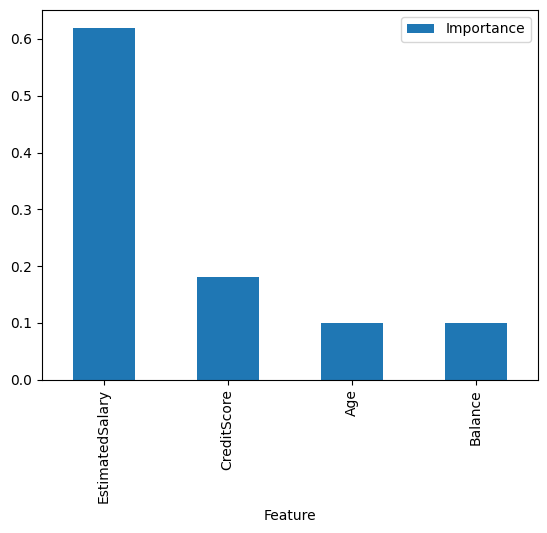

In [25]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [27]:
disc.binner_dict_['Tenure']

[-inf, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, inf]

In [30]:
label_map = ['1','2','3','4','5','6','7','8','9','10']
label_map

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [31]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
              Actual 1 Actual 2 Actual 3 Actual 4 Actual 5 Actual 6 Actual 7  \
Prediction 1       272      158      161      163      165      159      135   
Prediction 2         0        0        0        0        0        0        0   
Prediction 3         0        0        2        0        0        0        0   
Prediction 4         0        0        0        0        0        0        0   
Prediction 5         0        0        0        0        0        0        0   
Prediction 6         0        0        0        0        0        0        0   
Prediction 7         0        0        0        0        0        0        2   
Prediction 8         0        0        0        0        0        0        0   
Prediction 9         0        0        3        0        0        0        0   
Prediction 10        0        0        0        0        0        0        0   

              Actual 8 Actual 9 Actual 10  
Prediction 1       154    

/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/BankCustomerExitPredictor/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif